***CarND - Project 4 - Advanced Lane Detection ***

>This code detects the lane lines from a video and marks the lanes with color using the following steps:***

> *1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.*

> *2. Apply a distortion correction to raw images.*

> *3. Use color transforms, gradients, etc., to create a thresholded binary image.*

> *4. Apply a perspective transform to rectify binary image ("birds-eye view").*

> *5. Detect lane pixels and fit to find the lane boundary.*

> *6. Determine the curvature of the lane and vehicle position with respect to center.*

> *7. Warp the detected lane boundaries back onto the original image.*

> *8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.*

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle

from skimage import img_as_ubyte
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

In [2]:
# Declare Constants/ variables used
nx = 9 # number of chessboard Corners
ny = 6
ksize = 9
d_thresh  = (0.7, 1.2)
sc_thresh = (170, 255) 
sx_thresh = (20, 100)
FILTER_SIZE = 20

**Step 1 - Camera Calibration**

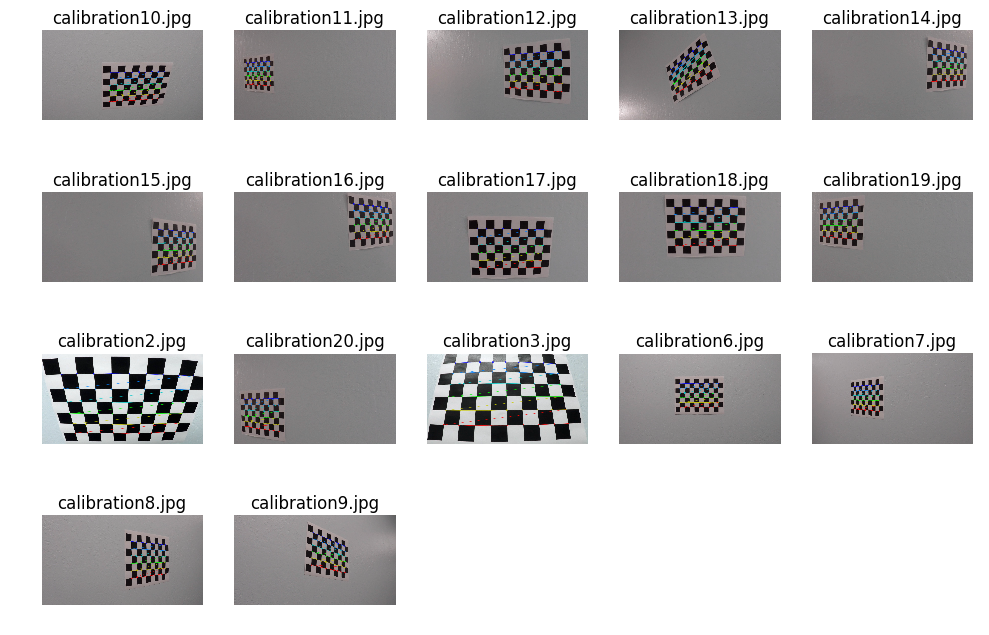

In [3]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(8,5,0)
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3D points in real world space
imgpoints = [] # 2D points in image plane.

# Make a list of calibration images
images = glob.glob('./CarND-Advanced-Lane-Lines-master/camera_cal/calibration*.jpg')
count = 0
plt.figure(figsize=(12, 8))
# Step through the list of images and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and store the corners found files 
        image_corners = cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        write_name = './corners_found/corners_found'+str(idx)+'.jpg'
        cv2.imwrite(write_name, img)
        
        # Display the Corners
        plt.subplot(4, 5, count+1)
        plt.axis('off')
        plt.title(fname.split('/')[-1])
        plt.imshow(image_corners)
        count += 1

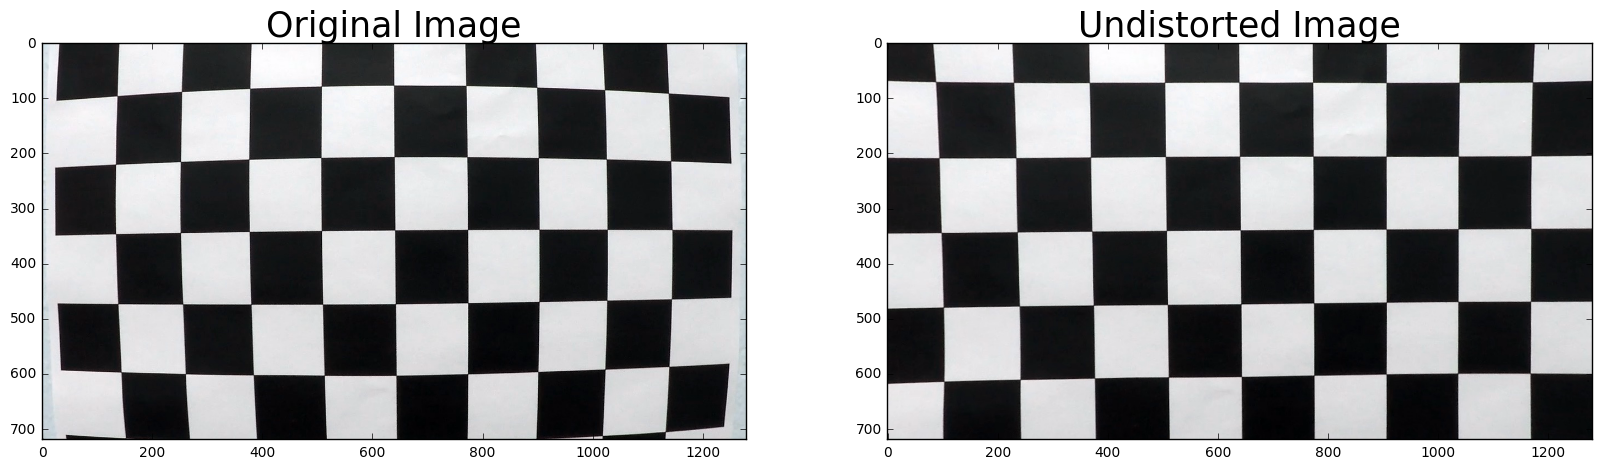

In [4]:
# Test undistortion on an image
img = cv2.imread('./CarND-Advanced-Lane-Lines-master/camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('./CarND-Advanced-Lane-Lines-master/output_images/calibration1_undist.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "./CarND-Advanced-Lane-Lines-master/output_images/camera_mtx_dist.p", "wb" ) )

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=25)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=25)

**Step 2 - Distortion Correction**

In [5]:
def load_camera_cal_params(pickle_fname):
    """ Loads from a pickle file the camera distortion matrix and distances.

    Parameter:
        - pickle_fname: Pickle file name.
    Returns:
        - (mtx, dist) tuple.
    """
    with open(pickle_fname, "rb") as pf:
        data = pickle.load(pf)
        return data['mtx'], data['dist']

pickle_fname = './CarND-Advanced-Lane-Lines-master/output_images/camera_mtx_dist.p'
mtx, dist = load_camera_cal_params(pickle_fname)

**Undistort and Test undistortion of Images**

In [6]:
def undistort_image(img, mtx, dist):
    """ Undistorts the input image. """
    return cv2.undistort(img, mtx, dist, None, mtx)

True

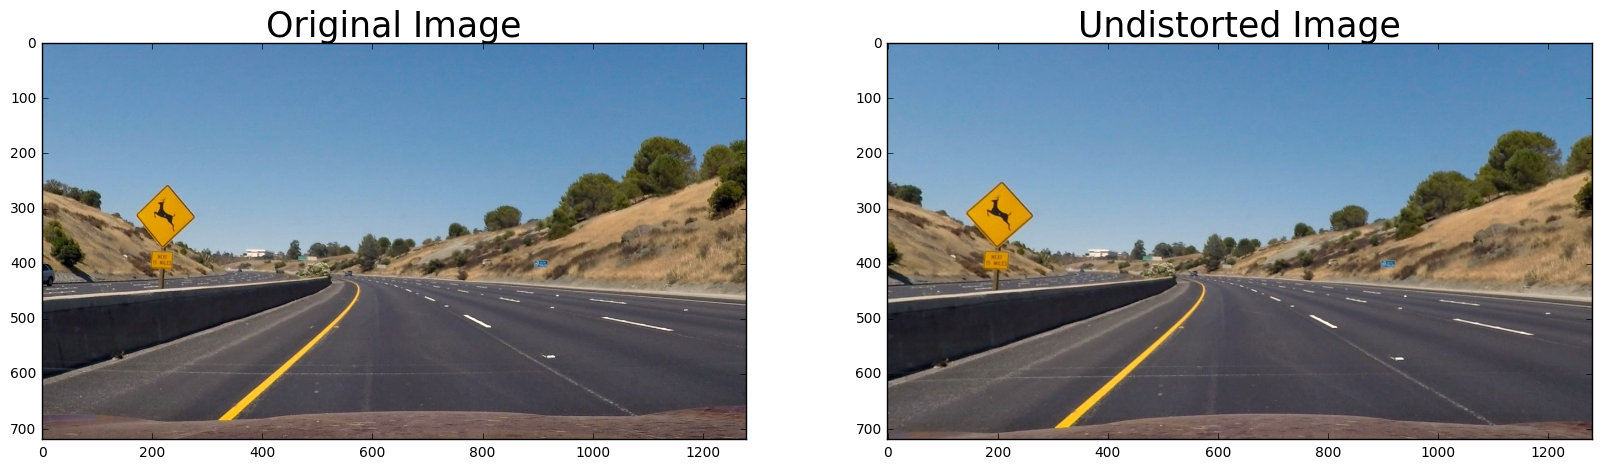

In [7]:
# Visualize undistortion

img_fname = './CarND-Advanced-Lane-Lines-master/test_images/test2.jpg'
img = cv2.imread(img_fname)
image_undistorted = undistort_image(img, mtx, dist)

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
image_undistorted= cv2.cvtColor(image_undistorted, cv2.COLOR_BGR2RGB) 

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=25)
ax2.imshow(image_undistorted)
ax2.set_title('Undistorted Image', fontsize=25)
# Save the file
cv2.imwrite('./CarND-Advanced-Lane-Lines-master/output_images/test2_undist.jpg',image_undistorted)

***Step 3 - Color/ Gradient Threshold and do a binary transform of the image***

In [8]:
def binary_xform(img, sobel_kernel=3, sc_thresh=(170, 255), sx_thresh=(20, 100)): # 110, 255
    """ Coverts the input image (img) from RGB colorspace to HLS and applies Sobel thresolding along 
        the x axis. 
        
        Returns a color binary image with only those pixels set to 1 iff the Sobel values were within 
        the sx_thresh and the S channel values were within the sc_thresh.
    """    
  
    # Convert to HLS color space and choose only the S channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    s_channel = hls[:,:,2] # Interested only in the S Channel
       
    # Grayscale image for sobel transformation
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Use Sobel x on the gray scale and scale it 8-bits
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
      
    # Threshold x gradient, default of 20 and 100 for min and max 
    sx_binary = np.zeros_like(scaled_sobel)
    sx_binary[(scaled_sobel>= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= sc_thresh[0]) & (s_channel <= sc_thresh[1])] = 1

    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components we can see as different colors
    color_binary = np.dstack(( np.zeros_like(sx_binary), sx_binary, s_binary))
    
    # Create a comined binary image.
    combined_binary = np.zeros_like(sx_binary)
    combined_binary[(sx_binary == 1) | (s_binary == 1)] = 1

    return combined_binary

True

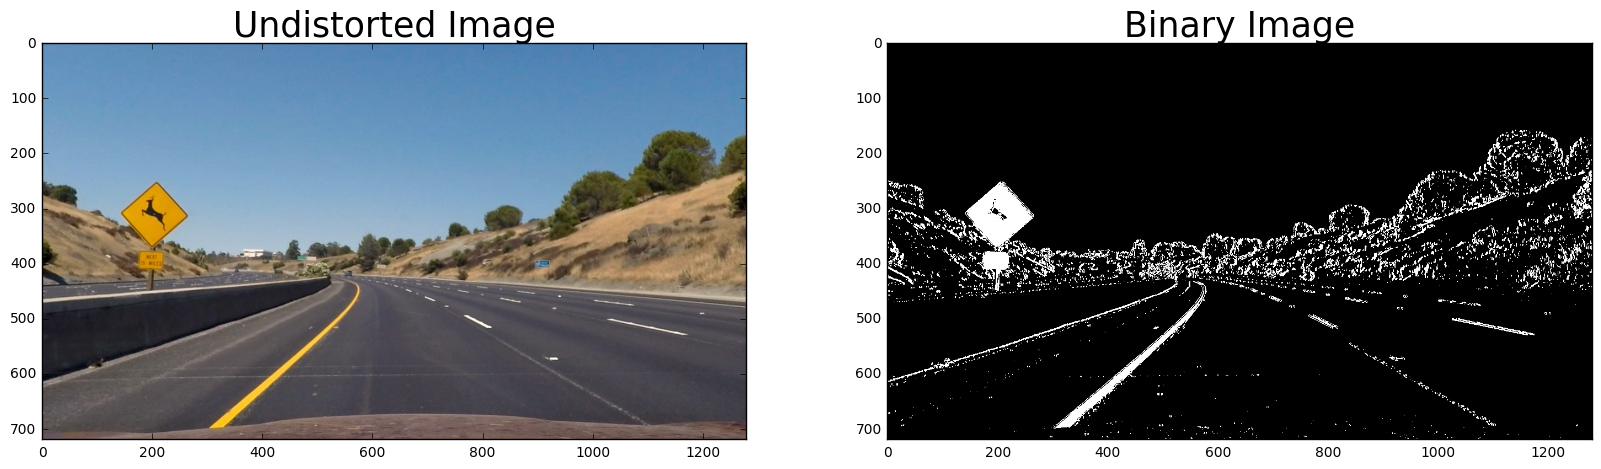

In [9]:
# Visualize the thresolded binary image
img_binary = binary_xform(image_undistorted)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(image_undistorted)
ax1.set_title('Undistorted Image', fontsize=25)
ax2.imshow(img_binary, cmap='gray')
ax2.set_title('Binary Image', fontsize=25)
# Save the file
cv2.imwrite('./CarND-Advanced-Lane-Lines-master/output_images/test2_undistorted_binary.jpg',img_binary)

**Step 4 - Perspective Transform - Get a bird's eye view of the road**

In [10]:
def perspective_xform(img):
    """ Apply perspective transformation on input image.
        Returns: The transformed input image (Bird's Eye) as uint8 type.
    """
    img_h = img.shape[0]
    img_w = img.shape[1]
    
    top_left     = [580,  460]
    top_right    = [740,  460] 
    bottom_left  = [280,  680]
    bottom_right = [1050, 680] 

    src = np.float32([top_left, bottom_left, top_right, bottom_right])
    dst = np.float32([[200,0], [200,680], [1000,0], [1000,680]])

    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)

    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, (img_w, img_h), flags=cv2.INTER_LINEAR) # Change
    return img_as_ubyte(warped), M

True

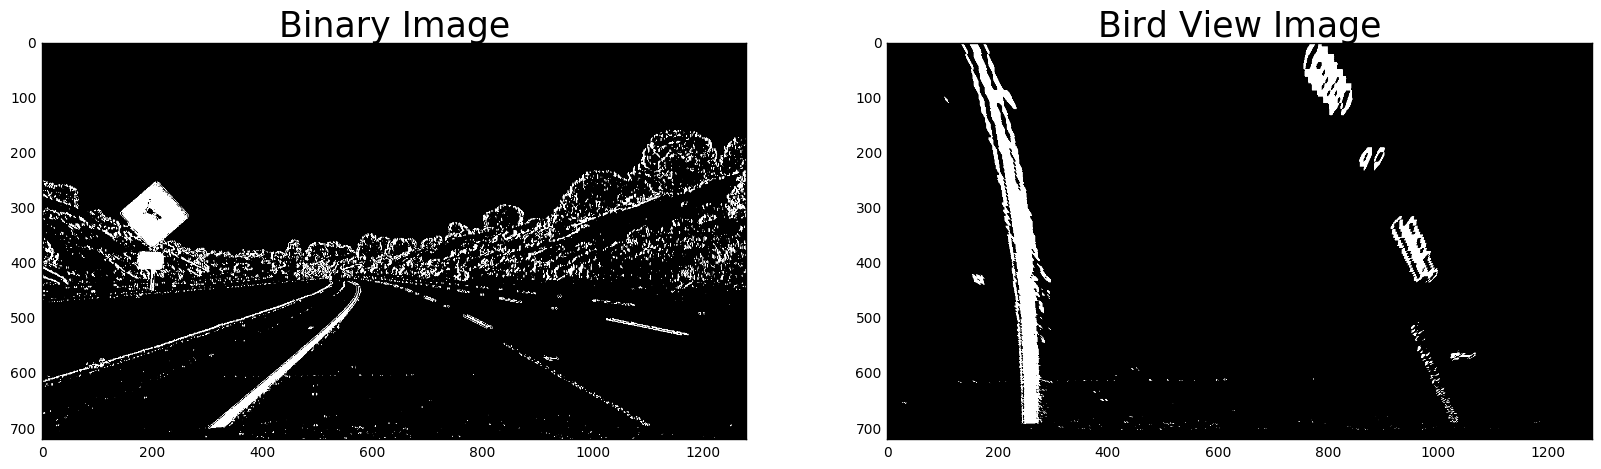

In [11]:
# Visualize perspective transform
img_warped, M = perspective_xform(img_binary)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img_binary, cmap='gray')
ax1.set_title('Binary Image', fontsize=25)
ax2.imshow(img_warped, cmap = 'gray')
ax2.set_title('Bird View Image', fontsize=25)

cv2.imwrite('./CarND-Advanced-Lane-Lines-master/output_images/test2_warped.jpg',img_warped)

**Step 5. Detect lane pixels and fit to find the lane boundary**

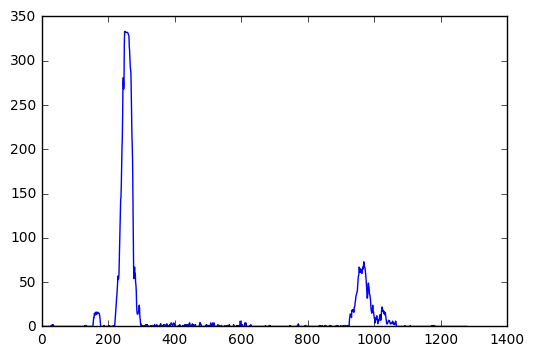

In [12]:
def plot_histogram(img, axis = 0):
    histogram = np.sum(img[img.shape[0]/2:,:], axis=0)
    plt.plot(histogram)
    return histogram

#img_binary = masked_binary
histogram = plot_histogram(img_warped)

*** Locate the lane lines and fit a polynomial ***

> *By identifying the peaks in the histogram and using a sliding window*

In [13]:
def locate_lane_lines(binary_warped):
    
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 80 # 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                          (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                           (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
           
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    ### Generate x and y values for plotting, and plot the figures
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    # Compute curve radius    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    left_curverad =  ((1 + (2*left_fit_cr[0] *y_eval*ym_per_pix + left_fit_cr[1])**2) **1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    # Determine the car position
    m_car = binary_warped.shape[1] / 2
    m_lane = (left_fitx[0] + right_fitx[0]) / 2
    offset_right_from_center_m = (m_lane-m_car)*xm_per_pix
    
    # Now our radius of curvature is in meters
    avg_radius_meters = np.mean([left_curverad, right_curverad])
    return out_img, avg_radius_meters, offset_right_from_center_m, left_fitx, right_fitx, ploty

(720, 0)

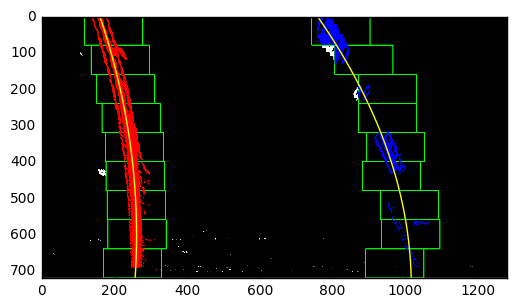

In [14]:
# Visulaize the result after the sliding window
img_lines, r_meters, right_from_center_m, l_fit, r_fit, ploty = locate_lane_lines(img_warped)
    
plt.imshow(img_lines)
plt.plot(l_fit, ploty, color='yellow')
plt.plot(r_fit, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

***Skip the sliding windows step once the lane lines are known***

In [15]:
def locate_lane_lines_after(binary_warped):
    
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) 
                      & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) 
                       & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Compute curve radius    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
   
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    left_curverad =  ((1 + (2*left_fit_cr[0] *y_eval*ym_per_pix + left_fit_cr[1])**2) **1.5)/np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5)/np.absolute(2*right_fit_cr[0])

    # Determine the car position with respect to the lane
    m_car = binary_warped.shape[1] / 2
    m_lane = (left_fitx[0] + right_fitx[0]) / 2
    offset_right_from_center_m = (m_lane-m_car)*xm_per_pix
    
    # The radius of curvature is in meters
    avg_radius_meters = np.mean([left_curverad, right_curverad])
    return out_img, avg_radius_meters, offset_right_from_center_m, left_fitx, right_fitx, ploty

In [16]:
def project_on_real_world_image(image, warped, Minv, left_fitx, right_fitx, ploty):
    
    # Create an image to draw the lines on
    color_warp = np.zeros_like(warped).astype(np.uint8)
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0]))

    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    return result

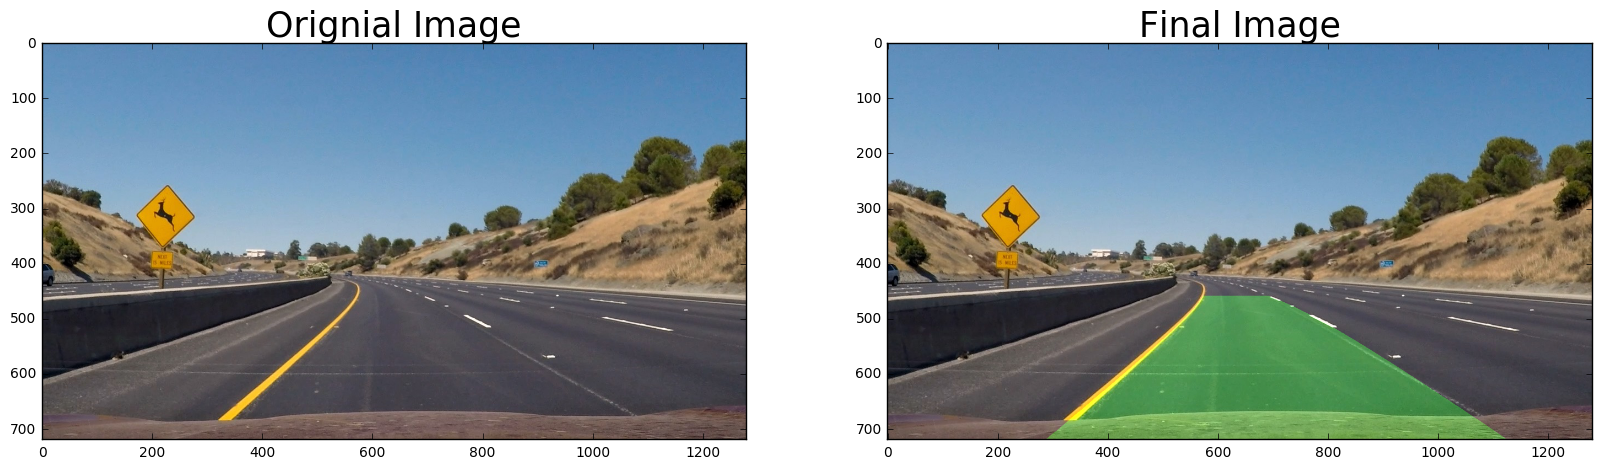

In [17]:
# Visualize the result
Minv = np.linalg.inv(M)
final_output = project_on_real_world_image(img, img_lines, Minv, l_fit, r_fit, ploty)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Orignial Image', fontsize=25)
ax2.imshow(final_output)
ax2.set_title('Final Image', fontsize=25)

**Test it on the final images **

In [18]:
def process_pipeline(input_image):
    # The output returned is a color image (3 channel) for processing video
    # and with lines drawn on lanes
        
    img_undist = undistort_image(input_image, mtx, dist)
    binary = binary_xform(img_undist, sobel_kernel=ksize, sc_thresh=sc_thresh, sx_thresh=sx_thresh )
    warped, M = perspective_xform(binary)
    vertices = np.array([[(200, 700),(200, 0), (1150, 0), (1200,710)]], dtype=np.int32)     
    img_lines, r_meters, right_from_center_m, l_fit, r_fit, ploty = locate_lane_lines(warped)
    
    # Smooth over the last n frames of video to obtain a cleaner result. Each time we get 
    # a new high-confidence measurement, we append it to the list of recent measurements 
    # and then take an average over n past measurements to obtain the lane position you want to draw onto the image.
    
    global l_fit_buffer
    global r_fit_buffer
    global previous_img_lines
    
    if previous_img_lines is None:
        previous_img_lines = binary

    ret = cv2.matchShapes(previous_img_lines, binary, 1, 0.0)
    
    if ret < 50:
        previous_img_lines = binary

        if l_fit_buffer is None:
            l_fit_buffer = np.array([l_fit])

        if r_fit_buffer is None:
            r_fit_buffer = np.array([r_fit])

        l_fit_buffer = np.append(l_fit_buffer, [l_fit], axis=0)[-FILTER_SIZE:]
        r_fit_buffer = np.append(r_fit_buffer, [r_fit], axis=0)[-FILTER_SIZE:]

    # Compute the mean
    l_fit_mean = np.mean(l_fit_buffer, axis=0)
    r_fit_mean = np.mean(r_fit_buffer, axis=0)
    
    Minv = np.linalg.inv(M)
    final_output = project_on_real_world_image(input_image, img_lines, Minv, l_fit_mean, r_fit_mean, ploty)
    
    # Superimpose the image with text
    font = cv2.FONT_HERSHEY_SIMPLEX
    text = "Radius of Curvature of the Lane is {:.0f} m".format(r_meters)
    cv2.putText(final_output, text, (50,50), font, 1, (255,255,255), 2)
    text = "Car Position from center offset right by {:.2f} m".format(right_from_center_m)
    cv2.putText(final_output, text, (50,100), font, 1, (255,255,255), 2)
    
    #return np.hstack((final_output, img_lines))
    final_output = np.array(final_output)
    return final_output

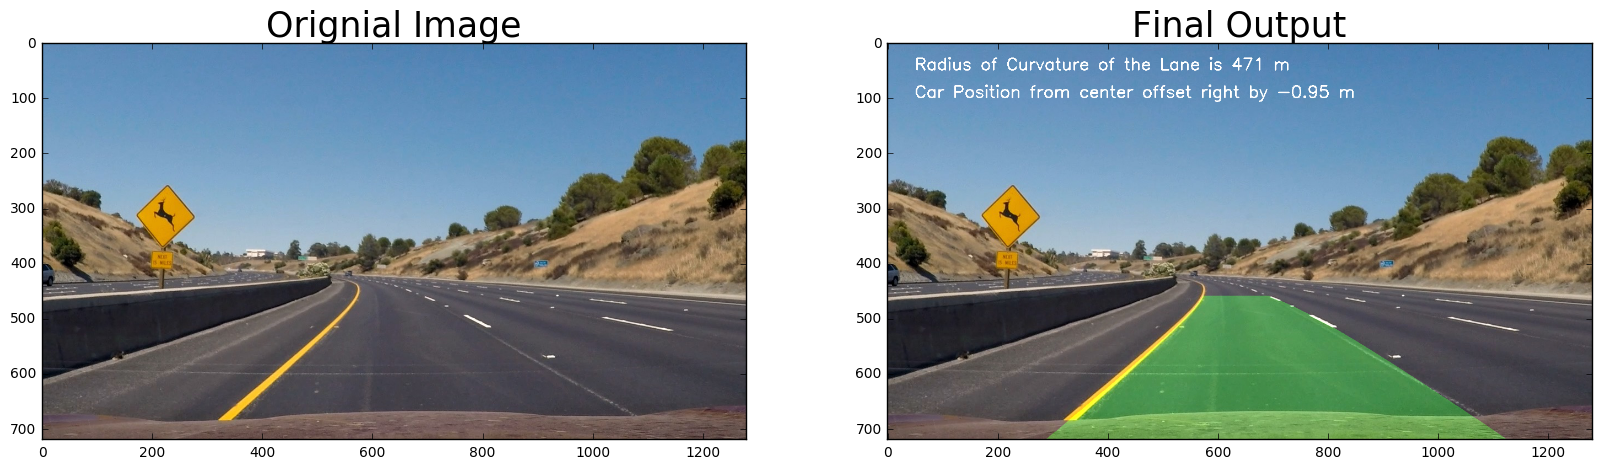

In [19]:
previous_img_lines = None
l_fit_buffer = None
r_fit_buffer = None

r = process_pipeline(img)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Orignial Image', fontsize=25)
ax2.imshow(r)
ax2.set_title('Final Output', fontsize=25)

In [20]:
project_video_output = "./CarND-Advanced-Lane-Lines-master/project_video_output.mp4"
clip1 = VideoFileClip("./CarND-Advanced-Lane-Lines-master/project_video.mp4")
white_clip = clip1.fl_image(process_pipeline)
%time white_clip.write_videofile(project_video_output, audio=False)

[MoviePy] >>>> Building video ./CarND-Advanced-Lane-Lines-master/project_video_output.mp4
[MoviePy] Writing video ./CarND-Advanced-Lane-Lines-master/project_video_output.mp4


100%|█████████▉| 1260/1261 [04:13<00:00,  5.60it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./CarND-Advanced-Lane-Lines-master/project_video_output.mp4 

CPU times: user 4min 11s, sys: 1min 30s, total: 5min 41s
Wall time: 4min 14s


In [21]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_video_output))

In [22]:
challenge_video_output = "./CarND-Advanced-Lane-Lines-master/challenge_video_output.mp4"
clip2 = VideoFileClip("./CarND-Advanced-Lane-Lines-master/challenge_video.mp4")
white_clip2 = clip2.fl_image(process_pipeline)
%time white_clip2.write_videofile(challenge_video_output, audio=False)

[MoviePy] >>>> Building video ./CarND-Advanced-Lane-Lines-master/challenge_video_output.mp4
[MoviePy] Writing video ./CarND-Advanced-Lane-Lines-master/challenge_video_output.mp4


100%|██████████| 485/485 [01:18<00:00,  6.51it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./CarND-Advanced-Lane-Lines-master/challenge_video_output.mp4 

CPU times: user 1min 33s, sys: 27.4 s, total: 2min
Wall time: 1min 19s


In [23]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_video_output))

In [24]:
harder_challenge_video_output = "./CarND-Advanced-Lane-Lines-master/harder_challenge_video_output.mp4"
clip2 = VideoFileClip("./CarND-Advanced-Lane-Lines-master/harder_challenge_video.mp4")
white_clip2 = clip2.fl_image(process_pipeline)
%time white_clip2.write_videofile(harder_challenge_video_output, audio=False)

[MoviePy] >>>> Building video ./CarND-Advanced-Lane-Lines-master/harder_challenge_video_output.mp4
[MoviePy] Writing video ./CarND-Advanced-Lane-Lines-master/harder_challenge_video_output.mp4


100%|█████████▉| 1199/1200 [04:15<00:00,  4.95it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./CarND-Advanced-Lane-Lines-master/harder_challenge_video_output.mp4 

CPU times: user 4min 13s, sys: 1min 23s, total: 5min 37s
Wall time: 4min 17s


In [25]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(harder_challenge_video_output))

** End of Workbook **